In [1]:
#default_exp ch1

# basic

The file wire.csv contains data relating the pull strength (pstren) of a wire bond (which we’ll treat as a response) to six characteristics which we shall treat as design variables: die height (dieh), post height (posth), loop height (looph), wire length (wlen), bond width on the die (diew), and bond width on the post (postw). (Derived from exercise 2.3 in Myers, Montgomery, and Anderson–Cook (2016) using data from Table E2.1.)

* Write code that converts natural variables in the file to coded variables in the unit hypercube. Also, normalize responses to have a mean of zero and a range of 1.
* Use model selection techniques to select a parsimonious linear model for the coded data including, potentially, second-order and interaction effects.
* Use the fitted model to make a prediction for pull strength, when the explanatory variables take on the values c(6, 20, 30, 90, 2, 2), in the order above, with a full accounting of uncertainty. Make sure the predictive quantities are on the original scale of the data.

In [2]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [12]:
#hide
from nbdev.showdoc import *
import pandas as pd
import numpy as np
import plotnine as pn
from typing import List

In [54]:
def length(x: pd.Series):
    return np.sqrt(np.sum(np.square(x)))

def _predictor_to_unit_length(x: pd.Series) -> pd.Series:
    return x / length(x)


class DataManager:
    def __init__(self, response="postw", datafile="http://bobby.gramacy.com/surrogates/wire.csv"):
        self.data = pd.read_csv(datafile)
        self.data.columns = [s.strip() for s in self.data.columns]
        self.response: str = response
        self.predictors: List[str] = self._get_predictors()
        self.normalized = False
        

    
    def _get_predictors(self) -> List[str]:
        return [colname for colname in self.data.columns if colname != self.response]

    
    def predictors_to_hypercube(self):
        for colname in self.predictors:
            self.data[colname] = _predictor_to_unit_length(self.data[colname])
            
    def normalize_response(self):
        if self.normalized:
            return
        self.orig_mean = np.mean(self.data[self.response])
        self.orig_std = np.std(self.data[self.response])
        self.data[self.response] -= self.orig_mean
        self.data[self.response] /= self.orig_std
        self.normalized = True
        
    def make_quadratic_variables_wide(self) -> pd.DataFrame:
        interactions = {}
        for coli in self.predictors:
            interactions[coli] = self.data[coli]
            for colj in self.predictors:
                interactions[f"{coli}*{colj}"] = self.data[coli] * self.data[colj]
        return pd.DataFrame(interactions)
    
    def make_quadratic_variables_long(self, wide=None):
        if wide is None:
            wide = self.make_quadratic_variables_wide()
        dfs = []
        idx = range(wide.shape[0])
        for colname in wide.columns:
            df = pd.DataFrame({'val': wide[colname]})
            df['var'] = colname
            df['response'] = self.data[self.response]
            dfs.append(df)
        return pd.concat(dfs)[['var', 'val', 'response']]


In [55]:
dm = DataManager()
dm.data.head()

,pstren,dieh,posth,looph,wlen,diew,postw
0,8.0,5.2,19.6,29.6,94.9,2.1,2.3
1,8.3,5.2,19.8,32.4,89.7,2.1,1.8
2,8.5,5.8,19.6,31.0,96.2,2.0,2.0
3,8.8,6.4,19.4,32.4,95.6,2.2,2.1
4,9.0,5.8,18.6,28.6,86.5,2.0,1.8


---------
### Write code that converts natural variables in the file to coded variables in the unit hypercube. Also, normalize responses to have a mean of zero and a range of 1.

In [56]:
dm.predictors_to_hypercube()
dm.normalize_response()
dm.data.head()

,pstren,dieh,posth,looph,wlen,diew,postw
0,0.179626,0.205221,0.231706,0.210582,0.245585,0.230895,2.116610
1,0.186362,0.205221,0.234071,0.230502,0.232129,0.230895,-0.884554
2,0.190852,0.228901,0.231706,0.220542,0.248950,0.219900,0.315912
3,0.197588,0.252580,0.229342,0.230502,0.247397,0.241890,0.916145
4,0.202079,0.228901,0.219884,0.203468,0.223848,0.219900,-0.884554


In [57]:
# Test data standardization.
for colname in dm.predictors:
    x = dm.data[colname]
    assert x.max() <= 1    
    assert x.min() >= 0
    1 - length(x) <= 10e-7

---------
### Use model selection techniques to select a parsimonious linear model for the coded data including, potentially, second-order and interaction effects.

In [58]:
quadratics_wide = dm.make_quadratic_variables_wide()
quadratics_long = dm.make_quadratic_variables_long(quadratics_wide)

In [59]:
quadratics_wide.head()

,pstren,pstren*pstren,pstren*dieh,pstren*posth,pstren*looph,pstren*wlen,pstren*diew,dieh,dieh*pstren,dieh*dieh,...,wlen*looph,wlen*wlen,wlen*diew,diew,diew*pstren,diew*dieh,diew*posth,diew*looph,diew*wlen,diew*diew
0,0.179626,0.032265,0.036863,0.041620,0.037826,0.044113,0.041475,0.205221,0.036863,0.042116,...,0.051716,0.060312,0.056704,0.230895,0.041475,0.047385,0.053500,0.048622,0.056704,0.053312
1,0.186362,0.034731,0.038245,0.043622,0.042957,0.043260,0.043030,0.205221,0.038245,0.042116,...,0.053506,0.053884,0.053597,0.230895,0.043030,0.047385,0.054046,0.053222,0.053597,0.053312
2,0.190852,0.036425,0.043686,0.044222,0.042091,0.047513,0.041968,0.228901,0.043686,0.052395,...,0.054904,0.061976,0.054744,0.219900,0.041968,0.050335,0.050952,0.048497,0.054744,0.048356
3,0.197588,0.039041,0.049907,0.045315,0.045544,0.048883,0.047795,0.252580,0.049907,0.063797,...,0.057025,0.061205,0.059843,0.241890,0.047795,0.061097,0.055475,0.055756,0.059843,0.058511
4,0.202079,0.040836,0.046256,0.044434,0.041117,0.045235,0.044437,0.228901,0.046256,0.052395,...,0.045546,0.050108,0.049224,0.219900,0.044437,0.050335,0.048353,0.044742,0.049224,0.048356


In [60]:
quadratics_long

,var,val,response
0,pstren,0.179626,2.116610
1,pstren,0.186362,-0.884554
2,pstren,0.190852,0.315912
3,pstren,0.197588,0.916145
4,pstren,0.202079,-0.884554
...,...,...,...
14,diew*diew,0.043641,-0.884554
15,diew*diew,0.053312,0.916145
16,diew*diew,0.048356,-0.884554
17,diew*diew,0.053312,-0.884554


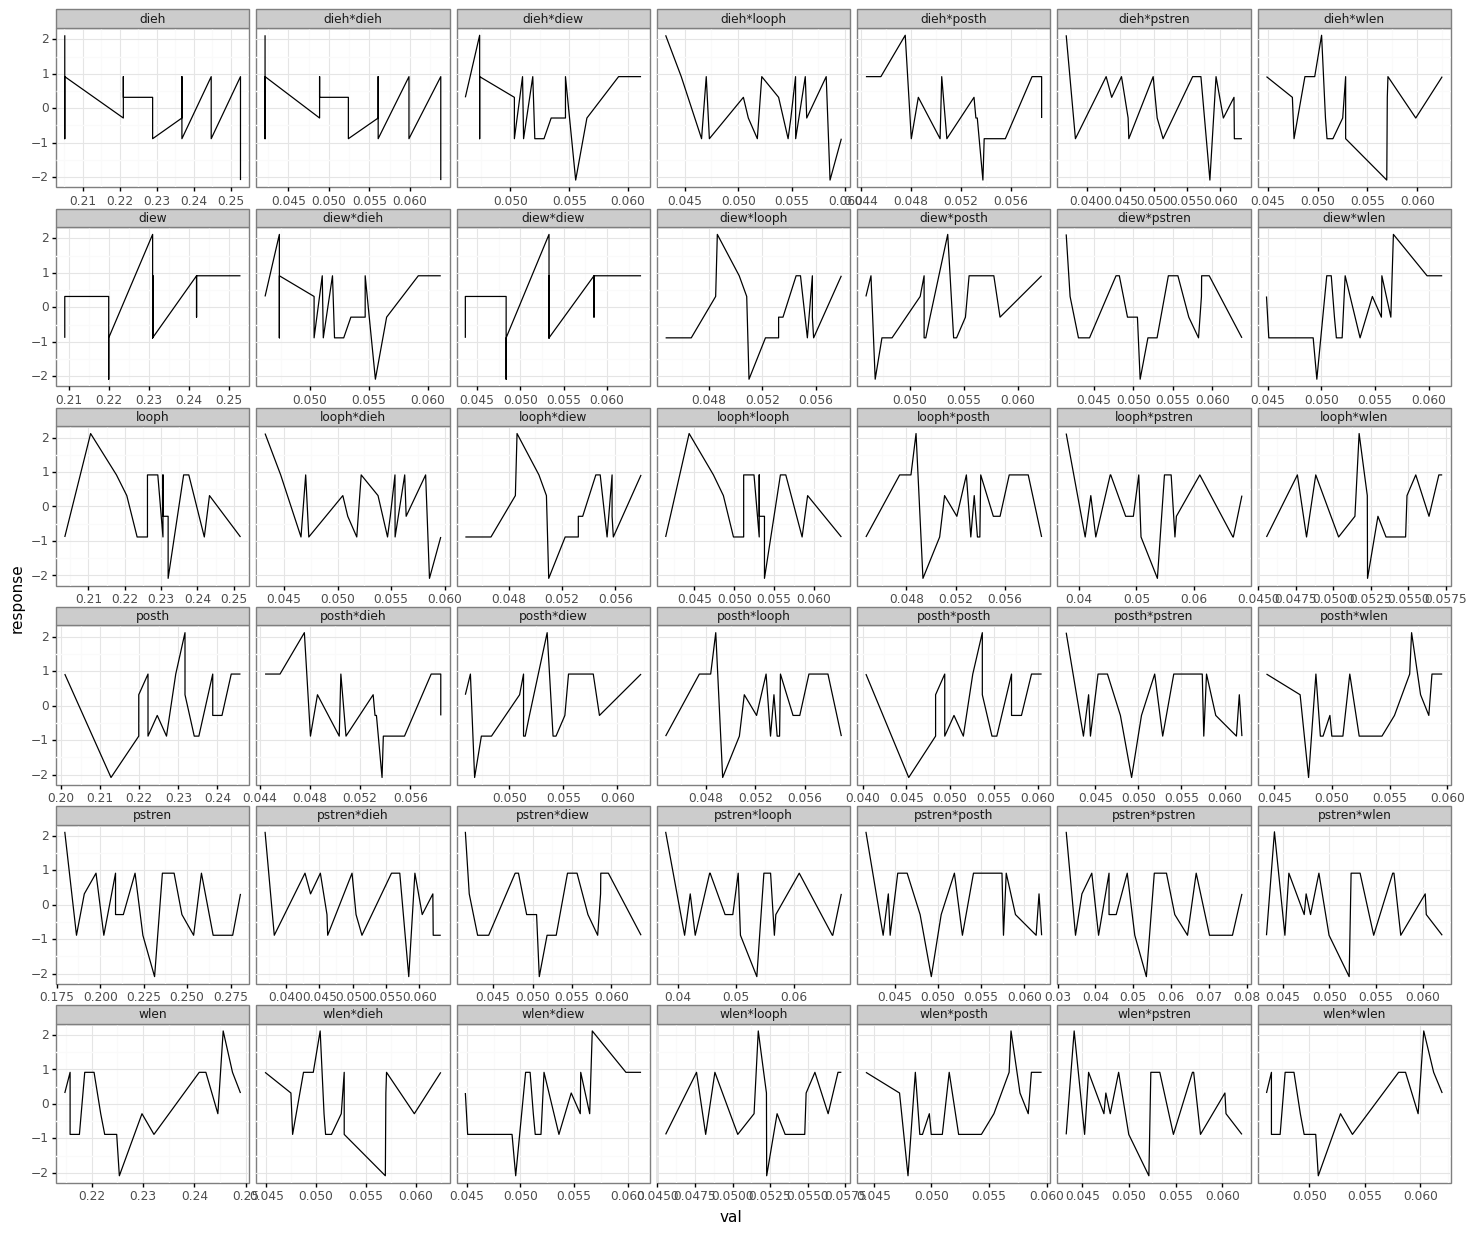

<ggplot: (8568295881277)>

In [79]:
plot_vars = quadratics_wide.columns #['pstren', 'dieh', 'pstren*dieh']
plot_df = quadratics_long[quadratics_long['var'].apply(lambda s: s in plot_vars)]
(pn.ggplot(plot_df, pn.aes(x='val', y='response')) +
 pn.geom_line() +
 pn.facet_wrap("var", scales='free_x') +
 pn.theme_bw() +
 pn.theme(subplots_adjust={'hspace': 0.25}, figure_size=(18, 15)))